# TP1: análisis exploratorio

## Definiciones de funciones generales, imports, y carga de datos

In [33]:
# magic function para hacer que los graficos de matplotlib se renderizen en el notebook.

import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

plt.style.use('bmh') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (18, 10)
%matplotlib inline

In [2]:
def show_and_save_plot(title,xlabel='', ylabel='', **kwargs):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig("./imgs/" + title + '.svg', **kwargs)
    plt.show()
    plt.close()

In [37]:
# https://stackoverflow.com/a/50558529\n,
def __my_flatten_cols(self, how="_".join, reset_index=True):
    how = (lambda iter: list(iter)[-1]) if how == "last" else how
    self.columns = [how(filter(None, map(str, levels))) for levels in self.columns.values] \
                    if isinstance(self.columns, pd.MultiIndex) else self.columns
    return self.reset_index() if reset_index else self
pd.DataFrame.my_flatten_cols = __my_flatten_cols

In [3]:
def event_grouper(event_list):
    result = []
    for event_name in event_list:
        def event_count_by_type(event_type, serie):
            return int(serie[serie == event_type].count())
        function = partial(event_count_by_type, event_name)
        function.__name__ = event_name
        result.append(function)
    return result

In [4]:
raw_events = pd.read_csv('data/events.csv').sort_values('timestamp')

/home/vasectomio/.virtualenv/datos/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocesamiento

In [5]:
brands = {'iphone':'apple', 'samsung':'samsung', 'lg':'lg', 'motorola':'motorola', \
            'sony':'sony', 'asus':'asus', 'quantum':'quantum', 'ipad':'apple', 'lenovo':'lenovo', \
             'blackberry' : 'blackberry'}
event_values = ['lead', 'conversion','staticpage','checkout','search engine hit', 'generic listing', 'ad campaign hit', 'visited site', 'brand listing', 'viewed product']
def findBrand(x):
    if(pd.isna(x)):
        return np.nan
    for key,value in brands.items():
        if(key in x.lower()):
            return value
    return np.nan
    

In [6]:
raw_events['brand'] = raw_events['model'].map(findBrand)

# Funciones de limpieza de datos/creacion de features

In [7]:
raw_events.timestamp = raw_events.timestamp.map(pd.Timestamp)
raw_events.time = raw_events.timestamp.map(lambda it: it.hour)
def megapixel_count(resolution):
    if type(resolution) != str: return np.NaN
    x_pixels, y_pixels = map(int, resolution.split("x"))
    return x_pixels*y_pixels/1000000
raw_events.screen_megapixels = raw_events.screen_resolution.map(megapixel_count)

/home/vasectomio/.virtualenv/datos/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/vasectomio/.virtualenv/datos/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


# Introduccion a los datos

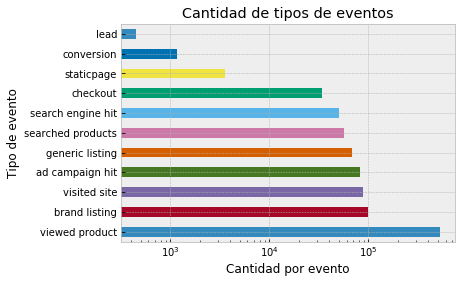

In [8]:
raw_events.event.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de eventos','Cantidad por evento', 'Tipo de evento')

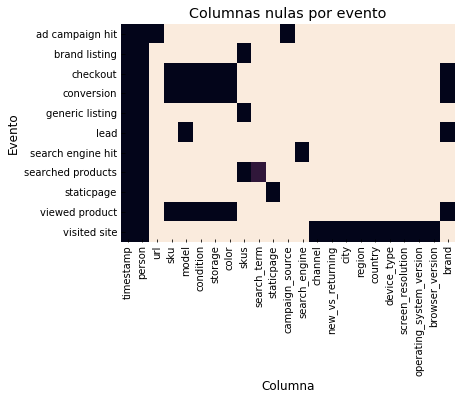

In [9]:
# Voy a intentar ver que proporcion de cada columna es nula
# Esto debería tener relación con que tipos de eventos tienen que atributos.
# Probablemente esta informacion salga de una db con un mapeo single_table
def myIsNa(serie):
    return serie.isna().sum() / len(serie.isna())
serie = pd.Series([1, 2, 3, np.NaN])
serie.isna().count()
grouped = raw_events.groupby('event').agg(myIsNa)
sns.heatmap(grouped, cbar=False)
show_and_save_plot('Columnas nulas por evento', 
                   xlabel='Columna', ylabel='Evento')
del grouped

# Exploracion de los distintos tipos de eventos por separado

## Eventos de busqueda

In [10]:
# Podemos ver que la columna 'sku', se corresponde con los tipos de evento relacionados a un solo dispositivo
# Por otro lado, la columna 'skus', tiene un string que se corresponde con un listado de dispositivos.
busquedas = raw_events[raw_events.event == 'searched products'][['skus','timestamp','person','search_term']]
# verifico que para el mismo usuario y search_term hay resultados distintos, para validar lo anterior
busquedas[(busquedas.search_term.isna()) & (busquedas.person == '00aaa92e')]
del busquedas

#### Motores de busqueda mas usados

In [11]:
raw_events['search_engine'].dropna().unique()

array(['Google', 'Bing', 'Yahoo', 'Ask'], dtype=object)

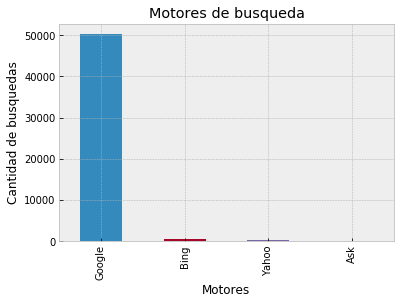

In [12]:
raw_events['search_engine'].dropna().value_counts().plot(kind = 'bar')
show_and_save_plot('Motores de busqueda', xlabel='Motores', ylabel='Cantidad de busquedas')

#### Veo cuales son los modelos que mas se compraron a traves de los distintos motores de busqueda.

In [13]:
search_events = raw_events[raw_events.event == 'ad campaign hit'].drop_duplicates(subset = 'person')
convertion_events = raw_events[raw_events.event == 'conversion']

In [14]:
search_and_buy = convertion_events.merge(search_events, how = 'inner', on = 'person')

In [15]:
len(search_and_buy)

962

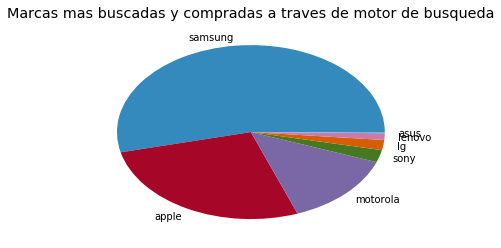

In [16]:
search_and_buy['brand_x'].value_counts().plot(kind = 'pie')
show_and_save_plot('Marcas mas buscadas y compradas a traves de motor de busqueda' )

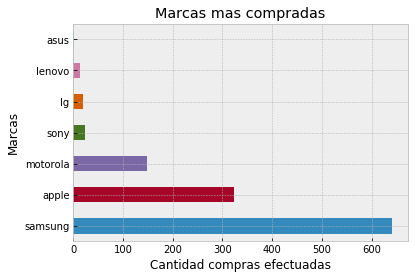

In [17]:
raw_events[raw_events.event == 'conversion']['brand'].value_counts().plot(kind = 'barh')
show_and_save_plot('Marcas mas compradas', xlabel='Cantidad compras efectuadas', ylabel='Marcas')

In [18]:
search_and_buy['count'] = 1
pivot = pd.pivot_table(search_and_buy[['model_x', 'search_engine_y','count']], index= ['model_x', 'search_engine_y'], aggfunc = 'count')
pivot = pivot.reset_index().pivot('model_x', 'search_engine_y', 'count')
len(pivot)

KeyError: 'count'

In [ ]:
sns.heatmap(pivot[:20], cmap = 'YlGnBu')
show_and_save_plot('Grilla de modelos buscados y comprados - 1', xlabel='Motores', ylabel='Modelos')

In [ ]:
sns.heatmap(pivot[20:50], cmap = 'YlGnBu')
show_and_save_plot('Grilla de modelos buscados y comprados - 2', xlabel='Motores', ylabel='Modelos')

In [ ]:
sns.heatmap(pivot[50:80], cmap = 'YlGnBu')
show_and_save_plot('Grilla de modelos buscados y comprados - 3', xlabel='Motores', ylabel='Modelos')

In [ ]:
sns.heatmap(pivot[80:], cmap = 'YlGnBu')
show_and_save_plot('Grilla de modelos buscados y comprados - 4', xlabel='Motores', ylabel='Modelos')

## Analisis de eventos por marcas

In [19]:
brand_conversion = raw_events[raw_events['event'] == 'conversion'][['brand','timestamp']]

In [20]:
brand_conversion['date'] = brand_conversion['timestamp'].map(lambda x: str(x.year) + "-" + str(x.month))

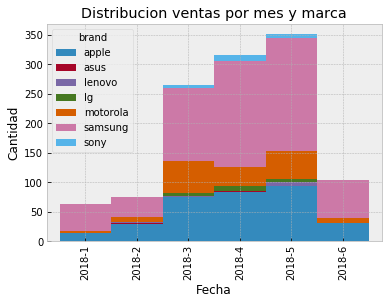

In [21]:
brand_conversion = brand_conversion.set_index('date')
brand_conversion.groupby(level='date').brand.value_counts().unstack('brand').plot.bar(stacked=True, width = 1)
show_and_save_plot('Distribucion ventas por mes y marca', xlabel='Fecha', ylabel='Cantidad')

## Eventos de visited_site

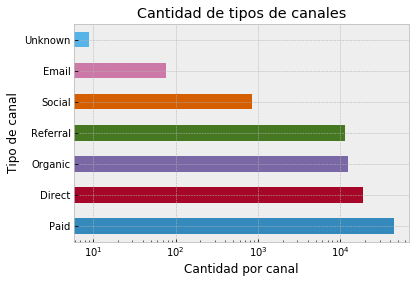

In [22]:
raw_events.channel.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de canales', xlabel='Cantidad por canal',
                    ylabel='Tipo de canal')

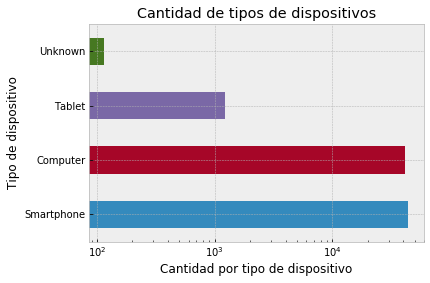

In [23]:
raw_events.device_type.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de dispositivos', xlabel='Cantidad por tipo de dispositivo', ylabel='Tipo de dispositivo')

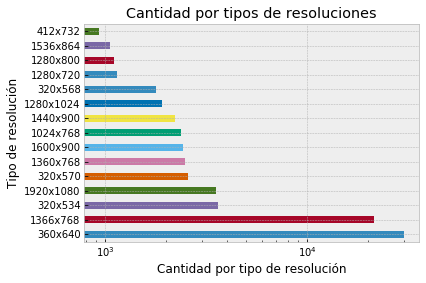

In [24]:
# Vemos que las resoluciones de pantalla son en general bajas, lo que da la idea
# de que la aplicación es usada por personas de bajo poder adquisitivo.
raw_events.screen_resolution.value_counts()[0:15].plot(kind='barh',logx=True)
show_and_save_plot('Cantidad por tipos de resoluciones', xlabel='Cantidad por tipo de resolución', 
                   ylabel='Tipo de resolución')

# Exploracion de todos los eventos en conjunto

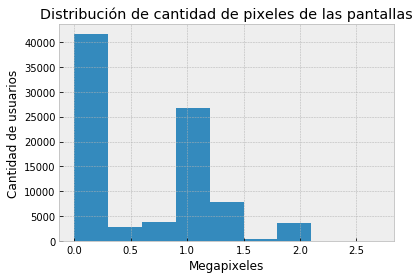

In [25]:
# Nos damos una idea de qué resoluciones de pantalla tienen los usuarios
raw_events.screen_megapixels.hist(bins=[x*0.3 for x in range(10)])
show_and_save_plot('Distribución de cantidad de pixeles de las pantallas', xlabel='Megapixeles',
                   ylabel='Cantidad de usuarios')

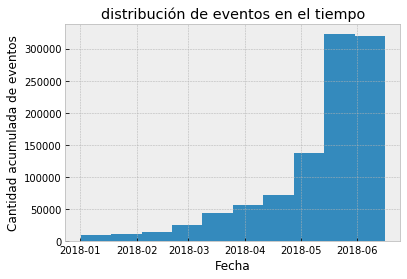

In [26]:
raw_events.timestamp.hist()
show_and_save_plot("distribución de eventos en el tiempo", xlabel='Fecha',
                   ylabel='Cantidad acumulada de eventos')

In [27]:
# Cuantos 'skus' distintos hay
print( "hay {} dispositivos y {} dispositivos distintos".format(len(raw_events.skus.dropna().values), len(raw_events.skus.dropna().unique())))

hay 221699 dispositivos y 35310 dispositivos distintos


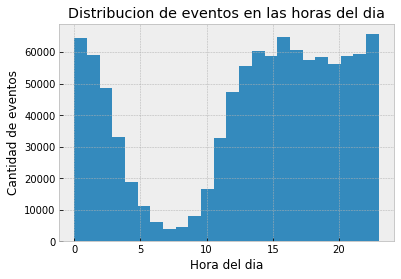

In [28]:
# Hora del dia en la que se producen los eventos:
raw_events.time.hist(bins=24)
show_and_save_plot('Distribucion de eventos en las horas del dia', xlabel='Hora del dia',
                   ylabel='Cantidad de eventos')

## Relación entre eventos de un mismo usuario
Primero voy a ver cuantos eventos hay por cada usuario ¿es usual que haya cientos por cada uno? ¿Solo un par?

In [38]:
def get_persons_data(raw_events):
    def first_event(series):
        return series.values[0]
    def last_event(series):
        return series.values[-1]
    persons = raw_events.groupby('person').agg({
        'timestamp':['min','max','count'],
        'event': event_grouper(event_values) + [first_event, last_event]
    })
    persons['time_spent'] = persons['timestamp','max'] - persons['timestamp','min']
    persons.time_spent = persons.time_spent.map(lambda it: it.total_seconds()/3600)
    return persons.my_flatten_cols().set_index('person')
def add_first_last_events(persons, raw_events):
    def get_last_and_first_events(row):
        events = raw_events[(raw_events.person == row.person) & (raw_events.timestamp == row.timestamp_min)]
        row['first_events'] = events.event.sort_values().str.cat(sep=', ')
        events = raw_events[(raw_events.person == row.person) & (raw_events.timestamp == row.timestamp_max)]
        row['last_events'] = events.event.sort_values().str.cat(sep=', ')
        return row
    return persons.apply(get_last_and_first_events, axis=1)

In [39]:
persons = get_persons_data(raw_events)

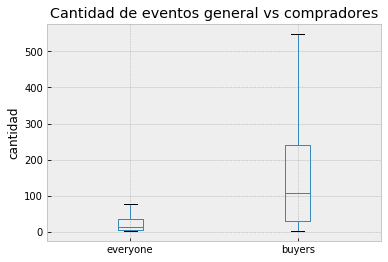

In [40]:
tempdf = pd.DataFrame()
tempdf['everyone'] = persons.timestamp_count
tempdf['buyers'] = persons[persons.event_conversion > 0].timestamp_count
tempdf.plot.box(showfliers=False)
show_and_save_plot('Cantidad de eventos general vs compradores', ylabel='cantidad')

In [41]:
persons.reset_index()

,person,timestamp_min,timestamp_max,timestamp_count,event_lead,event_conversion,event_staticpage,event_checkout,event_search engine hit,event_generic listing,event_ad campaign hit,event_visited site,event_brand listing,event_viewed product,event_first_event,event_last_event,time_spent
0,0004b0a2,2018-05-31 23:38:05,2018-05-31 23:38:40,4,0,0,0,1,0,0,1,1,0,1,visited site,checkout,0.009722
1,0006a21a,2018-05-29 13:29:25,2018-05-29 13:29:35,4,0,0,0,1,0,0,1,1,0,1,viewed product,checkout,0.002778
2,000a54b2,2018-04-09 20:12:31,2018-05-24 11:34:32,37,0,0,0,1,2,5,2,2,6,19,ad campaign hit,checkout,1071.366944
3,00184bf9,2018-04-06 05:12:05,2018-05-17 04:45:15,51,0,0,0,4,2,0,0,2,7,36,search engine hit,checkout,983.552778
4,0019c395,2018-05-17 00:08:56,2018-05-17 00:11:26,8,0,0,0,1,2,0,2,1,0,2,ad campaign hit,checkout,0.041667
5,001bb7eb,2018-06-06 18:40:51,2018-06-08 12:19:50,7,0,0,0,1,1,0,1,2,0,2,viewed product,checkout,41.649722
6,001f1653,2018-05-29 12:56:08,2018-05-29 12:56:27,4,0,0,0,1,0,0,1,1,0,1,ad campaign hit,checkout,0.005278
7,00204059,2018-01-18 00:19:28,2018-05-19 03:36:24,111,0,1,0,5,2,8,6,12,31,44,generic listing,checkout,2907.282222
8,0020f73c,2018-06-12 19:44:12,2018-06-12 19:44:12,1,0,0,0,1,0,0,0,0,0,0,checkout,checkout,0.000000
9,0024a82b,2018-05-30 16:05:19,2018-05-30 16:05:55,7,0,0,0,1,0,0,1,1,0,4,ad campaign hit,checkout,0.010000


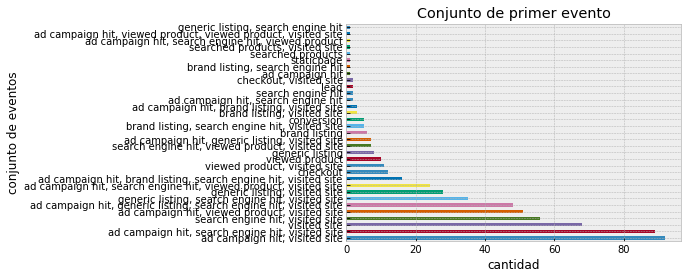

In [42]:
add_first_last_events(persons.sample(300).reset_index(), raw_events).first_events.value_counts().plot(kind='barh')
show_and_save_plot('Conjunto de primer evento',xlabel='cantidad',ylabel='conjunto de eventos')

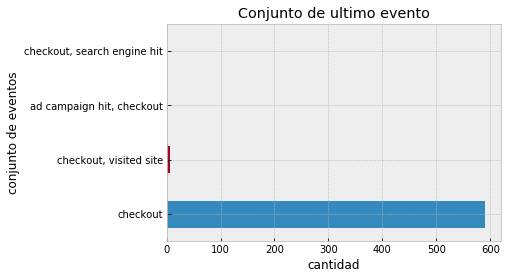

In [43]:
add_first_last_events(persons.sample(300).reset_index(), raw_events).last_events.value_counts().plot(kind='barh')
show_and_save_plot('Conjunto de ultimo evento',xlabel='cantidad',ylabel='conjunto de eventos')

In [44]:
raw_events[raw_events.event == 'visited site']

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,brand
571674,2018-01-01 07:32:26,visited site,9250d410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,São Paulo,Sao Paulo,Brazil,Smartphone,360x640,Android 5.0.2,Chrome Mobile 63.0,NaN
543839,2018-01-01 09:51:51,visited site,8b6dbd1d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Referral,New,Natal,Rio Grande do Norte,Brazil,Smartphone,360x640,Android 5.1.1,Chrome Mobile 55.0,NaN
543842,2018-01-01 12:40:21,visited site,8b6dbd1d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Direct,Returning,Natal,Rio Grande do Norte,Brazil,Smartphone,360x640,Android 5.1.1,Chrome Mobile 55.0,NaN
543849,2018-01-01 18:14:30,visited site,8b6dbd1d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Direct,Returning,Natal,Rio Grande do Norte,Brazil,Smartphone,360x640,Android 5.1.1,Chrome Mobile 55.0,NaN
889487,2018-01-01 18:27:36,visited site,e26651e3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,Embu,Sao Paulo,Brazil,Computer,1440x900,Windows 7,Chrome 63.0,NaN
249293,2018-01-01 22:38:36,visited site,4106b1a5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Social,New,Salvador,Bahia,Brazil,Computer,1366x768,Windows 10,Chrome 63.0,NaN
970092,2018-01-01 23:26:23,visited site,f5a3ced2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,Unknown,Unknown,Brazil,Smartphone,360x640,Android 6.0.1,Chrome Mobile 63.0,NaN
644803,2018-01-02 02:41:52,visited site,a51a7fa8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Organic,New,Unknown,Unknown,Unknown,Smartphone,360x640,Android 5.1.1,Chrome Mobile 63.0,NaN
319395,2018-01-02 04:35:48,visited site,53c89c12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,Campos dos Goytacazes,Rio de Janeiro,Brazil,Smartphone,360x640,Android 5.1.1,Chrome Mobile 60.0,NaN
543851,2018-01-02 09:30:44,visited site,8b6dbd1d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Direct,Returning,Natal,Rio Grande do Norte,Brazil,Smartphone,360x640,Android 5.1.1,Chrome Mobile 55.0,NaN


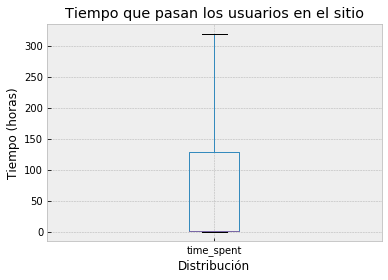

In [45]:
# Si muestro los outliers usa mucho espacio para los mismos, arriba del boxplot
persons.time_spent.plot(kind='box', showfliers=False)
show_and_save_plot('Tiempo que pasan los usuarios en el sitio',xlabel='Distribución', ylabel='Tiempo (horas)')

In [46]:
raw_events[raw_events.person=='000a54b2'].event.values[-1]

'checkout'

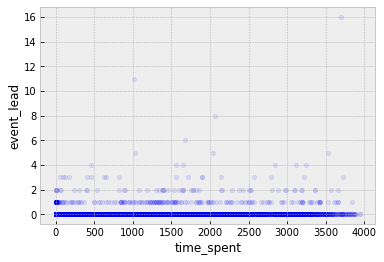

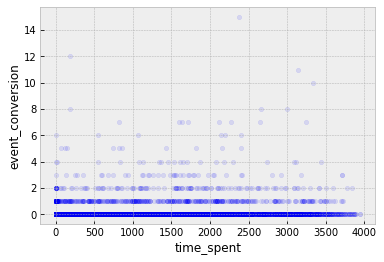

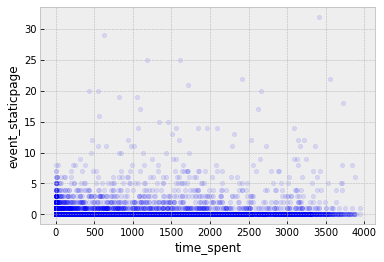

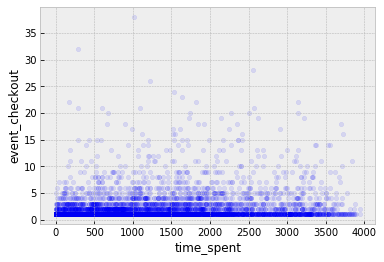

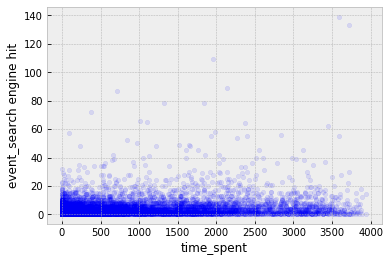

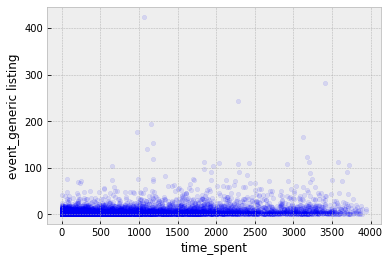

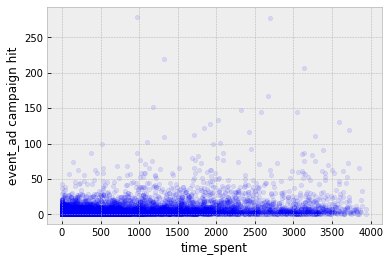

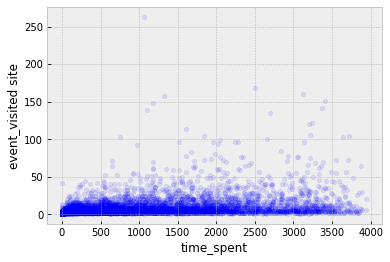

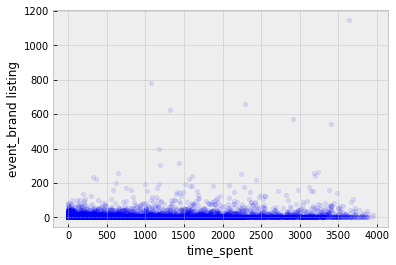

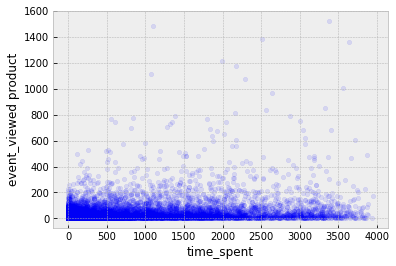

In [47]:
# NO hay relacion evidente entre el tiempo que se pasa en la plataforma y la cantidad de eventos que tiene. Ni siquiera es lineal.

for i in map(lambda it: 'event_'+it, event_values):
    persons.plot.scatter('time_spent', i, alpha=0.1)
plt.show()

In [48]:
raw_events[raw_events.person == '000a54b2'].sort_values('timestamp')

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,brand
11,2018-04-09 20:12:31,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2018-04-09 20:12:31,search engine hit,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-04-09 20:12:31,visited site,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,Rio de Janeiro,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome 65.0,NaN
8,2018-04-09 20:12:31,generic listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"10310,13333,13347,9902,9944,12774,12801,12744,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2018-04-09 20:12:53,brand listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"5075,12536,12520,12661,12506,12549,10449,9175,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2018-04-09 20:13:14,viewed product,000a54b2,NaN,12661,Motorola Moto Z Play,Muito Bom,32GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,motorola
14,2018-04-09 20:13:20,brand listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"5075,12536,12520,12661,12506,12549,10449,9175,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2018-05-24 11:21:07,visited site,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,Returning,Rio de Janeiro,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome 66.0,NaN
15,2018-05-24 11:21:07,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2018-05-24 11:21:07,search engine hit,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


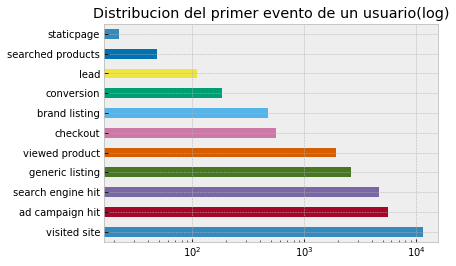

In [49]:
persons.event_first_event.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Distribucion del primer evento de un usuario(log)')

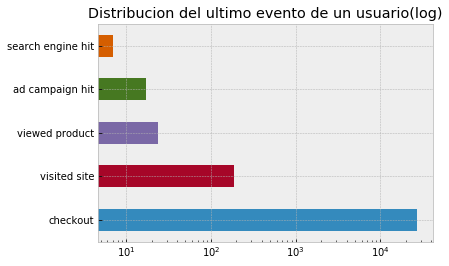

In [50]:
persons.event_last_event.value_counts().plot(kind='barh', logx=True)
show_and_save_plot('Distribucion del ultimo evento de un usuario(log)')

In [51]:
#En vista de que hay muchos usuarios cuyo ultimo evento es un checkout, me interesa si es el unico
print("hay ",
      (persons.event_last_event == 'checkout').size,
      "usuarios con ultimo evento checkout, y ",
      (persons.timestamp_count).size,
      "usuarios con un unico evento")

hay  27624 usuarios con ultimo evento checkout, y  27624 usuarios con un unico evento


## Features de cada modelo

In [52]:
def get_models_data(raw_events):
    def event_count_by_type(event_type, serie):
        return int(serie[serie == event_type].count())
    def viewed_product(it):
        return event_count_by_type('viewed product',it)
    def checkout(it):
        return event_count_by_type('checkout',it)
    def conversion(it):
        return event_count_by_type('conversion',it)
    def lead(it):
        return event_count_by_type('lead',it)
    event_functions = [ viewed_product, checkout, conversion, lead]
    models = raw_events\
        .groupby('model')\
        .agg({'timestamp':['count','min','max'],'event':event_functions})
    models['cantidad_eventos'] = models['timestamp','count']
    models = models.drop(labels=[('timestamp','count')],axis=1)
    models = models[models.cantidad_eventos > 100]
    for i in ['checkout', 'conversion','lead','viewed_product']:
        models['event',i] = models['event',i]/models['cantidad_eventos']
    return models

In [ ]:
models = get_models_data(raw_events).sort_values('cantidad_eventos', ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
show_and_save_plot('Distribucion de eventos en los modelos mas populares', xlabel='Distribucion', ylabel='Modelo')

Modelos de telefono mas vendidos en proporcion a los eventos totales

Vale la pena aclarar que son modelos distintos a los mas populares

In [ ]:
models = models.sort_values([('event','conversion')], ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
plt.xlabel('Distribucion')
plt.ylabel('Modelo')
show_and_save_plot('Distribucion de eventos en los modelos con mejor conversion rate')

In [ ]:
models = models.sort_values([('event','lead')], ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
plt.xlabel('Distribución')
plt.ylabel('Modelo')
show_and_save_plot('Distribucion de eventos en los modelos mas reservados')

## Evaluo cuales son los colores mas vendidos.

In [ ]:
colors_count = raw_events[raw_events.event == 'conversion'].color.dropna().value_counts()

In [ ]:
plt.xlabel('Cantidad')
plt.ylabel('Color')
colors_count.plot(kind = 'barh')